In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Input, Layer, Subtract, Lambda
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.applications import vgg19
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
from keras import backend as K
from keras.layers import Layer

class WeightsIdentity(Layer):

    def __init__(self, kernel_initializer='glorot_uniform', kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.kernel_initializer = kernel_initializer
        self.kernel_constraint = kernel_constraint

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape[1:],
                                      initializer=self.kernel_initializer,
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel = K.reshape(self.kernel, (1,) + tuple(self.kernel.shape))
        return kernel

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_output_shape(self, input_shape):
        return input_shape
        
def custom_mean_squared_error(_, content_diff):
    return K.mean(K.square(content_diff))

def gram_matrix(X):
    _X = K.squeeze(X, 0)
    features = K.batch_flatten(K.permute_dimensions(_X, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return K.expand_dims(gram / K.cast(K.prod(_X.shape), 'float32'), axis=0)

def preprocess_image_array(image):
    assert np.max(image) > 1, 'Pixel values should be in the 0-255 range'
    image = np.expand_dims(image, axis=0)
    image = vgg19.preprocess_input(image)
    return image

def deprocess_image_array(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_model_chunk(model, from_layer, to_layer, include_from=False):
    model_chunk = Sequential()
    from_to_index = [i
                     for i, layer in enumerate(model.layers)
                     if (layer.name.startswith(from_layer) or layer.name.startswith(to_layer))]
    if not include_from:
        from_to_index[0] += 1
        
    for layer in model.layers[from_to_index[0]:from_to_index[1] + 1]:
        model_chunk.add(layer)

    return model_chunk

bgr_to_rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

def get_content_features_and_gram_matrix(image):
    input_img = Input(shape=image.shape)
    vgg_model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_img)
    style_tsr_1_gram = Lambda(gram_matrix)(vgg_model.get_layer('block1_conv1').output)
    style_tsr_2_gram = Lambda(gram_matrix)(vgg_model.get_layer('block2_conv1').output)
    style_tsr_3_gram = Lambda(gram_matrix)(vgg_model.get_layer('block3_conv1').output)
    style_tsr_4_gram = Lambda(gram_matrix)(vgg_model.get_layer('block4_conv1').output)
    style_tsr_5_gram = Lambda(gram_matrix)(vgg_model.get_layer('block5_conv1').output)
    content_tsr_features = vgg_model.get_layer('block5_conv2').output
    model = Model(
        inputs=input_img, 
        output=[
            content_tsr_features,
            style_tsr_1_gram,
            style_tsr_2_gram,
            style_tsr_3_gram,
            style_tsr_4_gram,
            style_tsr_5_gram
    ])
    return model.predict_on_batch(preprocess_image_array(image))

from keras.constraints import Constraint
from keras import backend as K

class WeightClip(Constraint):

    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, p):
        return K.clip(p, self.min_value, self.max_value)
    
def get_model(content_img, content_weight, style_weight, learning_rate=0.001, start_random=False, clip_weights=False):
    vgg_model = vgg19.VGG19(weights='imagenet', include_top=False)
    StyleExtractor1 = get_model_chunk(vgg_model, 'input', 'block1_conv1')
    StyleExtractor2 = get_model_chunk(vgg_model, 'block1_conv1', 'block2_conv1')
    StyleExtractor3 = get_model_chunk(vgg_model, 'block2_conv1', 'block3_conv1')
    StyleExtractor4 = get_model_chunk(vgg_model, 'block3_conv1', 'block4_conv1')
    StyleExtractor5 = get_model_chunk(vgg_model, 'block4_conv1', 'block5_conv1')
    ContentExtractor = get_model_chunk(vgg_model, 'block5_conv1', 'block5_conv2')
    
    input_img = Input(shape=content_img.shape)
    weights = None if start_random else [np.squeeze(preprocess_image_array(content_img))]
    constraint = WeightClip(min_value=-123.68, max_value=255 - 123.68) if clip_weights else None
    combination_tsr = WeightsIdentity(
        name="combination_tsr",
        weights=weights,
        kernel_constraint=constraint
    )(input_img)
    combination_tsr_style_1 = StyleExtractor1(combination_tsr)
    combination_tsr_style_2 = StyleExtractor2(combination_tsr_style_1)
    combination_tsr_style_3 = StyleExtractor3(combination_tsr_style_2)
    combination_tsr_style_4 = StyleExtractor4(combination_tsr_style_3)
    combination_tsr_style_5 = StyleExtractor5(combination_tsr_style_4)
    combination_tsr_content = Lambda(ContentExtractor, name='combination_tsr_content_features')(combination_tsr_style_5)
    combination_tsr_style_1_gram = Lambda(gram_matrix, name='combination_tsr_style_1_gram')(combination_tsr_style_1)
    combination_tsr_style_2_gram = Lambda(gram_matrix, name='combination_tsr_style_2_gram')(combination_tsr_style_2)
    combination_tsr_style_3_gram = Lambda(gram_matrix, name='combination_tsr_style_3_gram')(combination_tsr_style_3)
    combination_tsr_style_4_gram = Lambda(gram_matrix, name='combination_tsr_style_4_gram')(combination_tsr_style_4)
    combination_tsr_style_5_gram = Lambda(gram_matrix, name='combination_tsr_style_5_gram')(combination_tsr_style_5)
    model = Model(
        inputs=input_img, 
        output=[
            combination_tsr_content,
            combination_tsr_style_1_gram,
            combination_tsr_style_2_gram,
            combination_tsr_style_3_gram,
            combination_tsr_style_4_gram,
            combination_tsr_style_5_gram
    ])
    for layer in model.layers:
        if layer.name != 'combination_tsr':
            layer.trainable = False
            
    losses = {
        'combination_tsr_content_features': 'mean_squared_error',
        'combination_tsr_style_1_gram': 'mean_squared_error',
        'combination_tsr_style_2_gram': 'mean_squared_error',
        'combination_tsr_style_3_gram': 'mean_squared_error',
        'combination_tsr_style_4_gram': 'mean_squared_error',
        'combination_tsr_style_5_gram': 'mean_squared_error'
    }
    loss_weights={
        'combination_tsr_content_features': content_weight,
        'combination_tsr_style_1_gram': style_weight / 5,
        'combination_tsr_style_2_gram': style_weight / 5,
        'combination_tsr_style_3_gram': style_weight / 5,
        'combination_tsr_style_4_gram': style_weight / 5,
        'combination_tsr_style_5_gram': style_weight / 5
    }

    model.compile(Adam(lr=learning_rate), loss=losses, loss_weights=loss_weights)
    return model

In [4]:
IMG_HEIGHT = 250
IMG_WIDTH = 400
N_CHANNELS = 3
CONTENT_WEIGHT = 0.25
STYLE_WEIGHT = 4

Imge type (shoud be int8): uint8


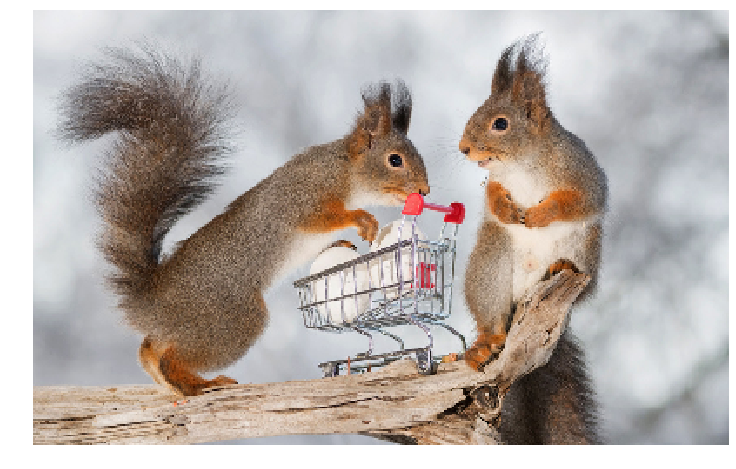

In [5]:
content_img = np.array(image.load_img('squirrel.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print('Imge type (shoud be int8):', content_img.dtype)
plt.imshow(content_img)
plt.axis('off');

In [6]:
content_features = get_content_features_and_gram_matrix(content_img)[0]

/home/rodrigo/anaconda3/envs/dl-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Imge type (shoud be int8): uint8


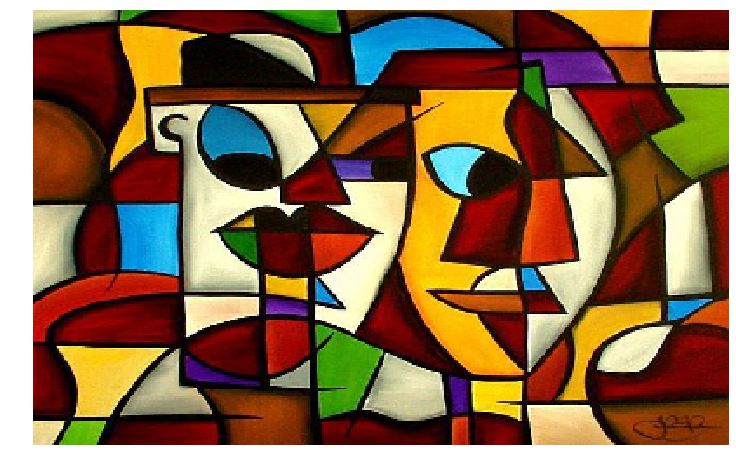

In [7]:
style_img = np.array(image.load_img('picasso_1.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print('Imge type (shoud be int8):', style_img.dtype)
plt.imshow(style_img)
plt.axis('off');

In [8]:
style_gram_matrices = get_content_features_and_gram_matrix(style_img)[1:]

/home/rodrigo/anaconda3/envs/dl-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [9]:
from keras.callbacks import Callback
 
class ShowCombination(Callback):
    def __init__(self, content_img, style_img):
        self.content_img = content_img
        self.style_img = style_img
        
    def on_epoch_end(self, epoch, logs={}):
        content_img = preprocess_image_array(self.content_img)
        style_img = preprocess_image_array(self.style_img)
        combination_img = deprocess_image_array(self.model.get_layer('combination_tsr').get_weights()[0])
        plt.imshow(np.hstack((self.content_img, combination_img, self.style_img)))
        plt.axis('off')
        plt.title('Content' + ' ' * 50 + 'Combination' + ' ' * 50 + 'Style')
        plt.show()

In [10]:
LEARNING_RATE = 10
model = get_model(content_img, CONTENT_WEIGHT, STYLE_WEIGHT, learning_rate=LEARNING_RATE, start_random=False, clip_weights=True)

/home/rodrigo/anaconda3/envs/dl-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [13]:
N = 1000

X = np.repeat(np.expand_dims(content_img, axis=0), N, axis=0)
_style_gram_matrices = [np.repeat(m, N, axis=0) for m in style_gram_matrices]
y = [np.repeat(content_features, N, axis=0)] + _style_gram_matrices

Epoch 1/1
1000/1000 [==============================] - 29s 29ms/step - loss: 16986.9593 - combination_tsr_content_features_loss: 7150.6786 - combination_tsr_style_1_gram_loss: 136.9281 - combination_tsr_style_2_gram_loss: 2281.3956 - combination_tsr_style_3_gram_loss: 2276.8975 - combination_tsr_style_4_gram_loss: 14176.3959 - combination_tsr_style_5_gram_loss: 127.4946


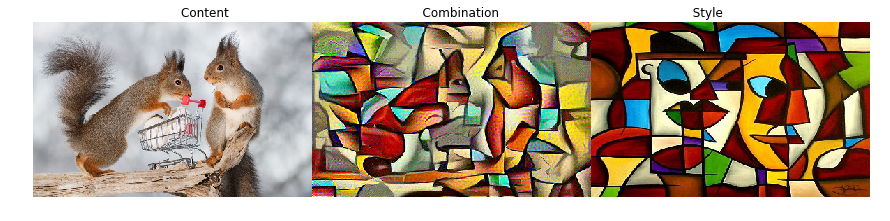

In [14]:
EPOCHS = 1
BATCH_SIZE = 1
model.fit(X, y,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          callbacks=[ShowCombination(content_img, style_img)]
)

(250, 400, 3)


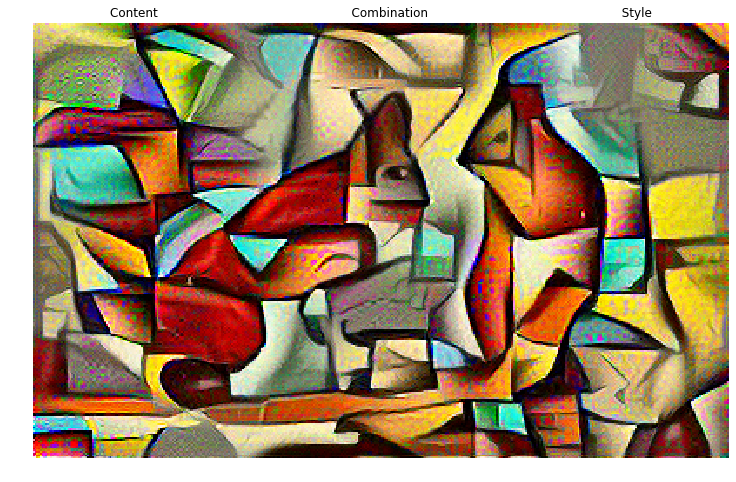

In [15]:
combination_img = deprocess_image_array(model.get_layer('combination_tsr').get_weights()[0])
print(combination_img.shape)
# plt.imshow(np.hstack((content_img, combination_img, style_img)))
plt.imshow(combination_img)
plt.axis('off')
plt.title('Content' + ' ' * 50 + 'Combination' + ' ' * 50 + 'Style')
plt.show()